In [52]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import holoviews as hv

import cartopy.crs as ccrs
import geoviews as gv

import hvplot.xarray
from mpl_toolkits.basemap import Basemap

import geopandas
import rioxarray
from shapely.geometry import mapping, Polygon
from scipy.interpolate import griddata
import yaml
import torch
import os
import shapely as sy
import geopandas as gpd
from osgeo import gdal,osr,ogr
import pickle

In [53]:
# load image
dataDIR = '/Users/jakravit/Desktop/H2014251184102_L2_polymer.nc'
ds = xr.open_dataset(dataDIR)

In [54]:
# get bands and coords
bands = ds.data_vars
for i in bands:

    if i in ['latitude']:
        lat = bands[i].values
    elif i in ['longitude']:
        lon = bands[i].values
    elif i in ['bitmask','Rnir','Rgli','logchl','bbs']:
        pass
    elif i in ['Rw410']:
        feats = bands[i].values
    else:
        feats = np.dstack((feats, bands[i]))

# transpose
feats = feats.transpose(2,0,1)
print (feats.shape)

(81, 2000, 512)


In [55]:
# flatten 3d array to shape n_samples(pixels) x n_features(bands)

flat_feats = np.array([feats[i].flatten() for i in range(feats.shape[0])]).transpose()
flat_feats2 = flat_feats / np.pi
print (flat_feats2.shape)

(1024000, 81)


In [56]:
from src.de_model import DE

def load_full_model(fpath):
    model = torch.load(fpath)
    model.eval()
    return model

def read_yaml(fpath_yaml):
    yml_conf = None
    with open(fpath_yaml) as f_yaml:
        yml_conf = yaml.load(f_yaml, Loader=yaml.FullLoader)
    return yml_conf

def predict(gmm, x):
    mus, sigma_sqs = [], []
    for i in range(gmm.num_models):
        model = getattr(gmm, 'model_' + str(i))

        with torch.no_grad():
            model.eval()

        mu, sigma_sq = model(x)
        mu = mu.detach().numpy()
        sigma_sq = sigma_sq.detach().numpy()
        mus.append(mu)
        sigma_sqs.append(sigma_sq)

    mus = np.squeeze(np.array(mus))
    sigma_sqs = np.squeeze(np.array(sigma_sqs))
    mixture_mus = np.mean(mus, axis=0)
    mixture_sigmas = np.mean((sigma_sqs + mus**2), axis=0) - mixture_mus**2
    mixture_sigmas = np.sqrt(mixture_sigmas)

    return mixture_mus, mixture_sigmas

def load_from_state(fpath, mdl, n_in, batch_info, strict=False):
    n_hidden = batch_info["n_hidden"]
    num_gaussians = batch_info["num_gaussians"]
    num_lin_layers = batch_info["num_lin_layers"]
    if mdl == "mdn":
        model = MDN(n_in, n_hidden, num_gaussians, num_lin_layers)
        model.load_state_dict(torch.load(fpath[0]), strict=strict)
    else:
        model = DE(num_models=num_gaussians, inputs=n_in, hidden_layers=n_hidden, n_lin_layers=num_lin_layers)
        for i in range(len(fpath)):
            ensemble_mem = getattr(model, 'model_' + str(i))
            ensemble_mem.load_state_dict(torch.load(fpath[i]), strict=strict)
    model.eval()
    return model

In [57]:
# DE config file
conf = '/Users/jakravit/Desktop/WaterQuality/conf/hico_conf_polymer_rrs_chl_v2.yaml'
conf = read_yaml(conf)
batch_info = conf['batch_info']

# model
params=[]
ppath = '/Users/jakravit/Desktop/WaterQuality/experiments/HICO_polymer_rrs_chl_v2/model_weights/'
for p in os.listdir(ppath):
    params.append(ppath+p)
XScalerFname = '/Users/jakravit/Desktop/WaterQuality/experiments/HICO_polymer_rrs_chl_v2/x_scaler.pkl'
YScalerFname = '/Users/jakravit/Desktop/WaterQuality/experiments/HICO_polymer_rrs_chl_v2/y_scaler.pkl'
Xscaler = pickle.load(open(XScalerFname,'rb'))
Yscaler = pickle.load(open(YScalerFname,'rb'))
flat_feats_log = np.where(flat_feats2>0, np.log(flat_feats2), flat_feats2)
# flat_feats_log = np.log(flat_feats2)
feats_scaled = Xscaler.transform(flat_feats_log)
n_in = feats_scaled.shape[1]
model = load_from_state(params, batch_info['model'], n_in, batch_info)
x_tensor = torch.from_numpy(np.float32(feats_scaled))
y_pred, unc = predict(model, x_tensor,)
pred_unscale = Yscaler.inverse_transform(np.vstack(y_pred) )
y_hat = pred_unscale[:,0].reshape(feats.shape[1], feats.shape[2])
# chl_unlog = np.exp(pred_unscale)[0,:]
# chl = chl_unlog.reshape(feats.shape[1], feats.shape[2])

/opt/anaconda3/envs/rasterio/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


In [ ]:
print (np.nanmin(chl))
print (np.nanmax(chl))
print (chl.shape)

4.4257908e-07
116.530655
(2000, 512)


# Plotting

In [77]:
chl = xr.Dataset(
    {"chl": (["x", "y"], y_hat)},
    coords={
        "lon": (["x", "y"], lon),
        "lat": (["x", "y"], lat)},
)
chl = chl.rio.write_crs("epsg:4326", inplace=True)

# plot band
green = xr.Dataset(
    {"green": (["x", "y"], bands['Rw811'].data/np.pi)},
    coords={
        "lon": (["x", "y"], lon),
        "lat": (["x", "y"], lat)},)

shape = geopandas.read_file('/Users/jakravit/data/greatLakesShp/hydro_p_LakeErie/hydro_p_LakeErie.shp', crs="epsg:4326")
shape = shape.dissolve()
min_x, min_y, max_x, max_y = shape.total_bounds
# clipped = da.rio.clip(shape.geometry.apply(mapping), shape.crs, drop=False, invert=False)

clipchl = chl.where((chl.lon<=max_x) & (chl.lon>=min_x) & (chl.lat<=max_y) & (chl.lat>=min_y), drop=False)
clipgreen = green.where((green.lon<=max_x) & (green.lon>=min_x) & (green.lat<=max_y) & (green.lat>=min_y), drop=False)

Text(0.5, 1.0, '553 nm')

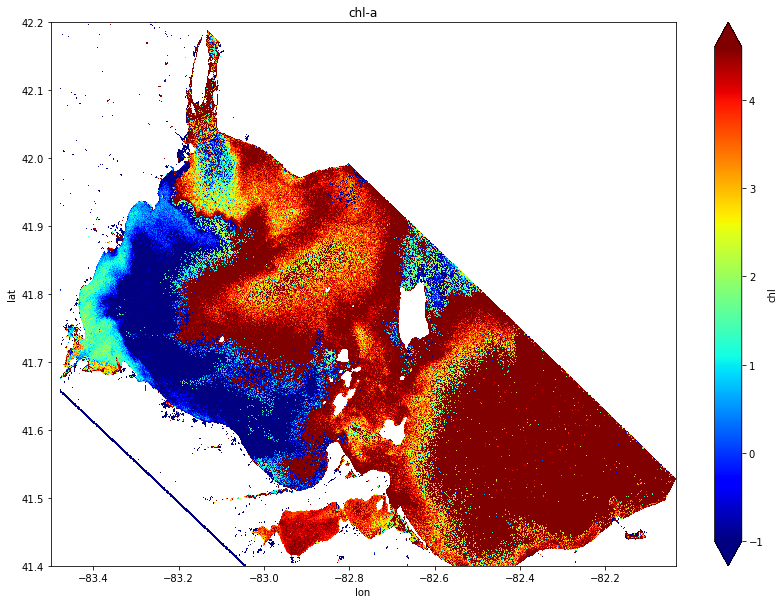

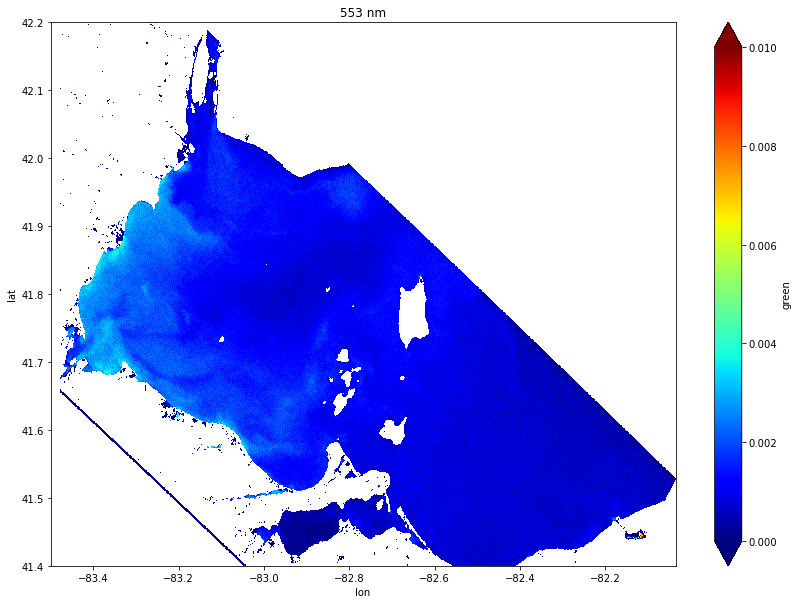

In [78]:
fig,ax = plt.subplots(figsize=(14,10))
clipchl.chl.plot(ax=ax, x='lon',y='lat',vmin=-1, vmax=4.6, cmap='jet')
ax.set_xlim(-83.5, lon.max())
ax.set_ylim(41.4, 42.2)
ax.set_title('chl-a')

fig,ax = plt.subplots(figsize=(14,10))
clipgreen.green.plot(ax=ax, x='lon',y='lat', vmin=0, vmax=.01, cmap='jet')
ax.set_xlim(-83.5, lon.max())
ax.set_ylim(41.4, 42.2)
ax.set_title('553 nm')